# Import Modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import datetime

In [2]:
OPENAI_API_KEY = ""
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [3]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage

# User-Defined Functions

In [4]:
# Read Raw data downloded in excel format
def read_raw_data (excel_file_name: str) -> pd.DataFrame:
    try:
        df = pd.read_excel(
            excel_file,
            parse_dates=[0],           # Parse first column as datetime
            dtype={1: 'Int64'},        # Safely handle large integers
            engine='openpyxl',         # Use openpyxl for .xlsx files    
        )
        #print(df.head(5))
    
    except Exception as e:
        print("Error reading Excel file:", e)

    return df

In [5]:
# Function to get sentiment using LangChain
def get_sentiment_with_langchain (text: str) -> str:
    prompt = prompt_template.format(text=text)
    try:
        response = llm([HumanMessage(content=prompt)])
        return response.content.strip()
    except Exception as e:
        print("Error processing:", text, "\n", e)
        return "Error"

In [6]:
def compute_sentiments (df: pd.DataFrame, text_sentiment_map: dict) -> pd.DataFrame:
    for text_key in text_sentiment_map.keys():
        print(text_key, text_sentiment_map[text_key])
        df[text_sentiment_map[text_key]] = df[text_key].apply(get_sentiment_with_langchain)

    return df

In [7]:
def visualize_sentiments (df: pd.DataFrame, text_sentiment_map: dict) -> None:
    num_text_types = len(text_sentiment_map.keys())
    fig, axes = plt.subplots(1, num_text_types, figsize=(12, 6))
    for sent_type_count, text_key in enumerate(text_sentiment_map.keys()):
        #print(text_key, text_sentiment_map[text_key])
        counts_sent = df[text_sentiment_map[text_key]].value_counts()
        axes[sent_type_count].pie(counts_sent, labels=counts_sent.index, autopct="%1.1f%%", startangle=90)
        axes[sent_type_count].set_title(text_key)
    
    plt.suptitle("Sentiment Distributions Across Text Columns", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [8]:
def reduce_df_to_a_sentiment (df_orig: pd.DataFrame, text_sentiment_map: dict, desired_sentiment: str) -> pd.DataFrame:
    df = df_orig.copy()
    for text_key in text_sentiment_map.keys():
        #print(text_key, text_sentiment_map[text_key])
        df = df [df[text_sentiment_map[text_key]] == desired_sentiment]

    return df
    

In [9]:
# Function to extract keywords and counts using OpenAI
def extract_keywords_with_counts(llm, prompt_template, text: str):
    prompt = prompt_template.format(text=text[:4000])  # truncate if needed
    response = llm([HumanMessage(content=prompt)])
    
    # Parse response into dict
    result = {}
    for line in response.content.strip().split("\n"):
        if ":" in line:
            try:
                key, val = line.split(":")
                result[key.strip()] = int(val.strip())
            except ValueError:
                continue
    return result

In [10]:
def extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, desired_sentiment, llm, prompt_template):
    # Reduce the data frame so that each text column has the same sentiment type
    df = reduce_df_to_a_sentiment (df_orig, text_sentiment_map, desired_sentiment)

    for sent_type_count, text_key in enumerate(text_sentiment_map.keys()):
        #print(text_key, text_sentiment_map[text_key])
        col = text_key
        text = " ".join(df[col].dropna().astype(str).tolist())
        result = extract_keywords_with_counts(llm, prompt_template, text)
    
        print(f"\nTop 10 keywords from column '{col}' that represent '{desired_sentiment}' sentiments:")
        for k, v in result.items():
            print(f"{k}: {v}")

# Read the Raw Data

In [11]:
excel_file = 'engagements.xlsx'
df = read_raw_data(excel_file)
df.head(5)

,timestamp,media_id,media_caption,comment_text
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️


# Proceed with a subset for Testing

In [12]:
##
df = df[0:100]

# Define LLM

In [13]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.0)

/tmp/ipykernel_1336609/2335869711.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.0)


# Analyze Sentiments

### Define a prompt template

In [14]:
prompt_template = PromptTemplate.from_template(
    "Classify the sentiment of the following text as Positive, Negative, or Neutral:\n\n{text}\n\nSentiment:"
)

### Define a map between column names with text and the corresponding sentiment

In [15]:
text_sentiment_map = {
    'media_caption': 'sentiment_media_caption',
    'comment_text': 'sentiment_comment_text',
    #'comment_text2': 'sentiment_comment_text2'
}

In [16]:
text_sentiment_map

{'media_caption': 'sentiment_media_caption',
 'comment_text': 'sentiment_comment_text'}

### Compute Sentiments

In [17]:
df = compute_sentiments (df, text_sentiment_map)
df_orig = df.copy()

media_caption sentiment_media_caption


/tmp/ipykernel_1336609/4098399969.py:5: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([HumanMessage(content=prompt)])


comment_text sentiment_comment_text


In [18]:
df

,timestamp,media_id,media_caption,comment_text,sentiment_media_caption,sentiment_comment_text
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,Positive
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good,Positive,Positive
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it,Positive,Positive
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...,Positive,Positive
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️,Positive,Positive
...,...,...,...,...,...,...
95,2025-03-01 23:37:53.524000+00:00,17950254656929862,Why use one scrub when you can use them all at...,So pretty,Positive,Positive
96,2025-03-01 23:47:56.769000+00:00,1090109099826112,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",Roberta Wimmer Stone Walmart,Positive,Neutral
97,2025-03-02 00:23:42.929000+00:00,18021315083459733,Orange you glad it’s giveaway time?! 🍊✨\n\nTha...,@_alyrrr,Positive,Neutral
98,2025-03-02 00:42:23.009000+00:00,17895078585072260,Y’all already know I’m a product junkie and a ...,@bathandbodyworks \n@blackgirlsunscreen \n@haw...,Positive,Neutral


### Visualize Sentiments

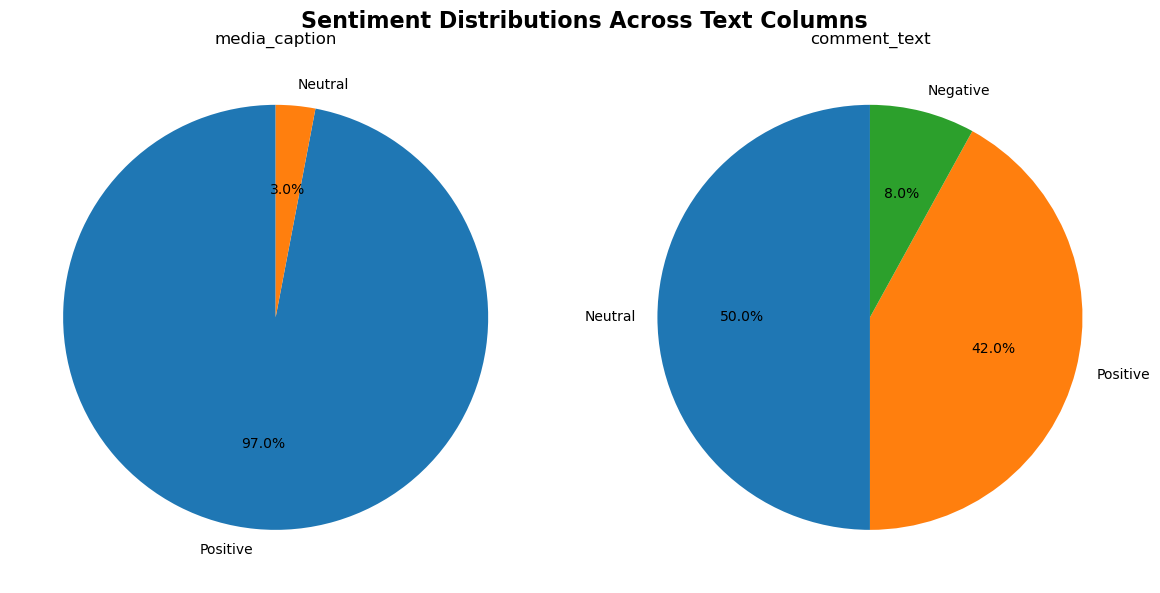

In [19]:
visualize_sentiments (df, text_sentiment_map)

# Obtain frequent words for each type of sentiment

### Define a prompt template

In [20]:
prompt_template = PromptTemplate.from_template(
    """Extract the top 10 most important keywords or phrases from the following text, and show how often each one appears. 
Return them in the format: keyword: count, one per line. Only include meaningful content words, not stopwords or punctuation.

Text:
{text}
"""
)

### Call function

In [21]:
extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, 'Positive', llm, prompt_template)


Top 10 keywords from column 'media_caption' that represent 'Positive' sentiments:
scrub: 10
use: 6
treehut: 6
hand: 5
collection: 5
orange: 5
self-care: 4
tangerine: 4
giveaway: 4
morning: 3

Top 10 keywords from column 'comment_text' that represent 'Positive' sentiments:
love: 10
scrub: 6
smell: 5
tree hut: 4
citrus: 3
coconut lime: 2
fragrance: 2
scent: 2
heavenly: 2
favorite: 2


In [22]:
extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, 'Negative', llm, prompt_template)


Top 10 keywords from column 'media_caption' that represent 'Negative' sentiments:

Top 10 keywords from column 'comment_text' that represent 'Negative' sentiments:


In [23]:
extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, 'Neutral', llm, prompt_template)


Top 10 keywords from column 'media_caption' that represent 'Neutral' sentiments:
time: 2
exfoliate: 2
WintHER scrub: 1
fits: 1
vibe: 1

Top 10 keywords from column 'comment_text' that represent 'Neutral' sentiments:
hello: 2
today: 2
wonderful: 2
doctor: 2
bradley shaffer: 2
friend: 2
name: 2
mind: 2
emerald tuesdae wells: 1
megan brohm: 1


# Other Stuff

In [24]:
# Media Type

In [25]:
#df['media_id'].value_counts()